In [1]:
import sys
import os
path_to_top_dir = "../"
# Dynamically add the `project` directory to the path
sys.path.append(os.path.abspath(path_to_top_dir))

In [2]:
# Utils
import warnings

# Plotting
from rdkit.Chem.Draw import MolsToGridImage
import matplotlib.pyplot as plt
import seaborn as sns
from pycirclize import Circos

# File management
import json
import numpy as np
import pandas as pd


# GFlowNET
import gflownet
from gflownet.algo.trajectory_balance import TrajectoryBalance
from gflownet.envs.graph_building_env import GraphBuildingEnv
from gflownet.config import init_empty, Config
from scent_gfn.molecule import MoleculeTask

# OpenPOM
from pom_models.functions import fragance_propabilities_from_smiles

# Others
from tensorboard.backend.event_processing import event_accumulator
import torch
from rdkit import Chem


Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\paulj\Desktop\prosjekt\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'
c:\Users\paulj\Desktop\prosjekt\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module impli

In [3]:

directory = "../results"
vanillasaves=[]
pinesaves=[]
# Iterate over files in directory
for name in os.listdir(directory):
    # Open file
    #print(name)
    if "vanilla" in name:
        vanillasaves.append(name)
    elif "pine" in name:
        pinesaves.append(name)

pinesaves,vanillasaves

(['pine1_2024-12-03__14_19_29', 'pine2_2024-12-08__20_52_30'],
 ['vanilla10_2024-12-07__10_47_14',
  'vanilla11_2024-12-13__20_56_37',
  'vanilla12_2024-12-13__22_27_31',
  'vanilla1_2024-12-03__18_44_11',
  'vanilla2_2024-12-03__20_50_10',
  'vanilla3_2024-12-03__22_12_54',
  'vanilla4_2024-12-04__09_23_46',
  'vanilla5_2024-12-04__15_17_35',
  'vanilla6_2024-12-04__22_30_41',
  'vanilla7_2024-12-05__11_23_44',
  'vanilla8_2024-12-05__22_21_26',
  'vanilla9_2024-12-06__20_41_11'])

In [4]:
def plot_save(ax, savename,label,color):
    
    cfg = init_empty(Config())

    cfg.log_dir = f"c:/Users/paulj/Desktop/prosjekt/pom_cpu-model/results/{savename}"
    ea = event_accumulator.EventAccumulator(cfg.log_dir)
    ea.Reload()
    ax[0].plot([i.value for i in ea.Scalars('train_loss')],  linewidth=1,label=label,color=color)
    ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')],  linewidth=1,label=label,color=color)
    return ax


In [5]:
vanillanames={
    "vanilla1": "OpenPOM, Cosine",
    "vanilla2": "Structure, Cosine",
    "vanilla3": "OpenPOM, Cosine, Exp.pen",
    "vanilla4": "OpenPOM, Cosine, Hard.pen",
    "vanilla5": "",
    "vanilla6": "",
    "vanilla7": "",
    "vanilla8": "OpenPOM, Cosine",
    "vanilla9": "Structure, Cosine, Beta",
    "vanilla10": "Structure, Cosine",
    "vanilla11": "OpenPOM, Tanimoto",
    "vanilla12": "Structure, Tanimoto",
}

In [15]:
vanillalst = ["", "vanilla8","vanilla9", "vanilla10","", "vanilla1", "vanilla2", "vanilla11", "vanilla12", "vanilla3","vanilla4"]  

In [7]:
def find_save(van_str):
    for save in vanillasaves:
        if van_str==save.split("_")[0]:
            return save
    return "not found"

In [8]:
for i in vanillalst:
    if i!="":
        print(find_save(i))

vanilla8_2024-12-05__22_21_26
not found
vanilla1_2024-12-03__18_44_11
vanilla2_2024-12-03__20_50_10
vanilla11_2024-12-13__20_56_37
vanilla12_2024-12-13__22_27_31
vanilla3_2024-12-03__22_12_54
vanilla4_2024-12-04__09_23_46


In [9]:
from matplotlib.lines import Line2D

In [10]:
len(sns.color_palette("Set2"))

8

In [11]:
print(find_save("vanilla10"))

vanilla10_2024-12-07__10_47_14



vanilla8
vanilla9
vanilla10

vanilla1
vanilla2
vanilla11
vanilla12
vanilla3
vanilla4


IndexError: list index out of range

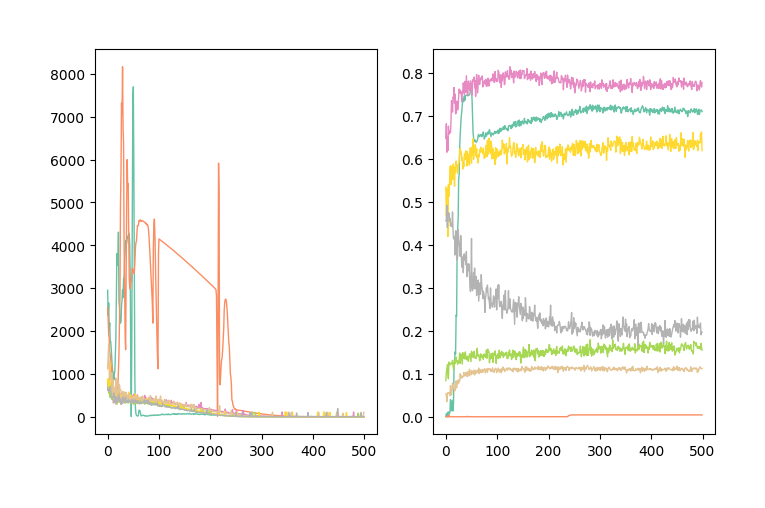

In [20]:
f, ax = plt.subplots(1, 2, figsize=(4*2,5))
handles = []
count = 0
for i, label in enumerate(vanillalst):
    print(label)
    if label!="" and label!="vanilla10":
        savename = find_save(label)
        color = sns.color_palette("Set2")[count]
        ax = plot_save(ax, savename,label,color)
        handles.append(plt.Line2D([], [], color=color, label=vanillanames[label], linewidth=2))
        count +=1
    elif label=="vanilla10":
        count +=1
    else:
        if i==0:
            handles.append(
                Line2D([0], [0], color='none', label='Atom-Based')
            )
        else:
            handles.append(
                Line2D([0], [0], color='none', label='Fragment-Based')
            )
    

ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[0].grid()
ax[1].set_ylabel('Average reward')
ax[1].grid()
#ax[1].set_xlabel('Iteration')
plt.tight_layout()
#plt.savefig(f"../images/vanilla_{number}_plots.pdf", bbox_inches="tight")
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

legend=plt.legend(
    handles=handles,
    loc='upper right',
    frameon=True,
    bbox_to_anchor=(1.8, 1),
    edgecolor="black",
    #title="Legend Title",
)

# Customize font styles
for text in legend.get_texts():
    if text.get_text() in ['Atom-Based', 'Fragment-Based']:  # Bold specific headers
        text.set_weight('bold')
        #text.set_size(7)  # Adjust size if desired
plt.savefig(f"../images/vanilla_all_plots.pdf", bbox_inches="tight")

In [42]:
pinenames = {
    "pine1": "OpenPOM, Cosine",
    "pine2": "OpenPOM, Cosine, Hard.pen"
}
pinelst= ["", "pine1", "pine2"]  
pinesaves

['pine1_2024-12-03__14_19_29', 'pine2_2024-12-08__20_52_30']

In [43]:
def find_save_pine(van_str):
    for save in pinesaves:
        if van_str==save.split("_")[0]:
            return save
    return "not found"

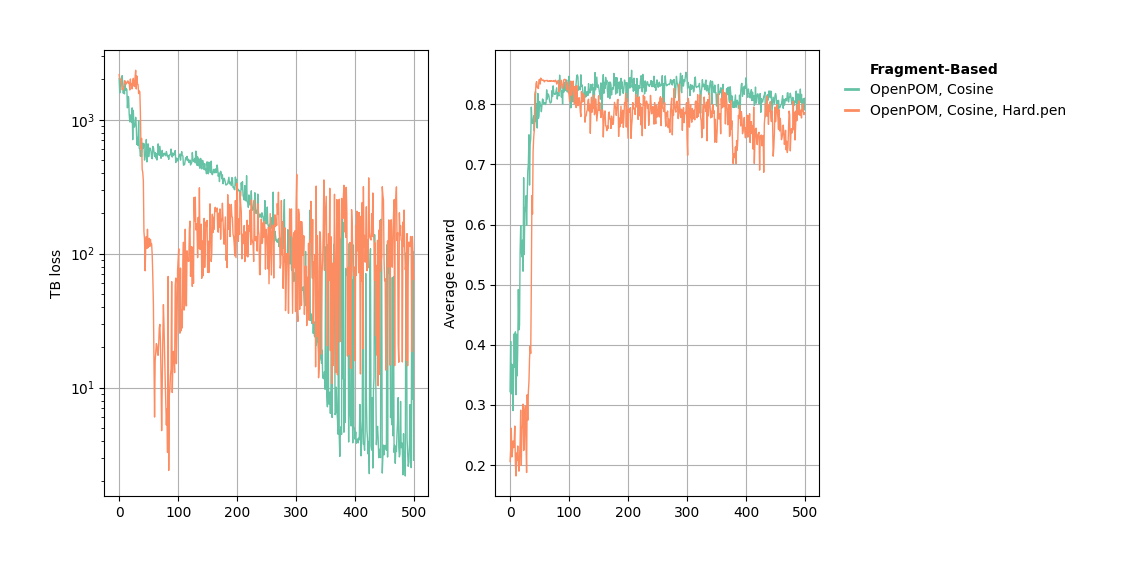

In [44]:
f, ax = plt.subplots(1, 2, figsize=(4*2,5))
handles = []
count = 0
for i, label in enumerate(pinelst):

    if label!="":
        savename = find_save_pine(label)
        color = sns.color_palette("Set2")[count]
        ax = plot_save(ax, savename,label,color)
        handles.append(plt.Line2D([], [], color=color, label=pinenames[label], linewidth=2))
        count +=1
        
    else:
        handles.append(
            Line2D([0], [0], color='none', label='Fragment-Based')
        )
    

ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[0].grid()
ax[1].set_ylabel('Average reward')
ax[1].grid()
#ax[1].set_xlabel('Iteration')
plt.tight_layout()
#plt.savefig(f"../images/vanilla_{number}_plots.pdf", bbox_inches="tight")
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

legend=plt.legend(
    handles=handles,
    loc='upper right',
    frameon=True,
    bbox_to_anchor=(1.8, 1),
    edgecolor="black",
    #title="Legend Title",
)

# Customize font styles
for text in legend.get_texts():
    if text.get_text() in ['Atom-Based', 'Fragment-Based']:  # Bold specific headers
        text.set_weight('bold')
        #text.set_size(7)  # Adjust size if desired
plt.savefig(f"../images/pine_all_plots.pdf", bbox_inches="tight")

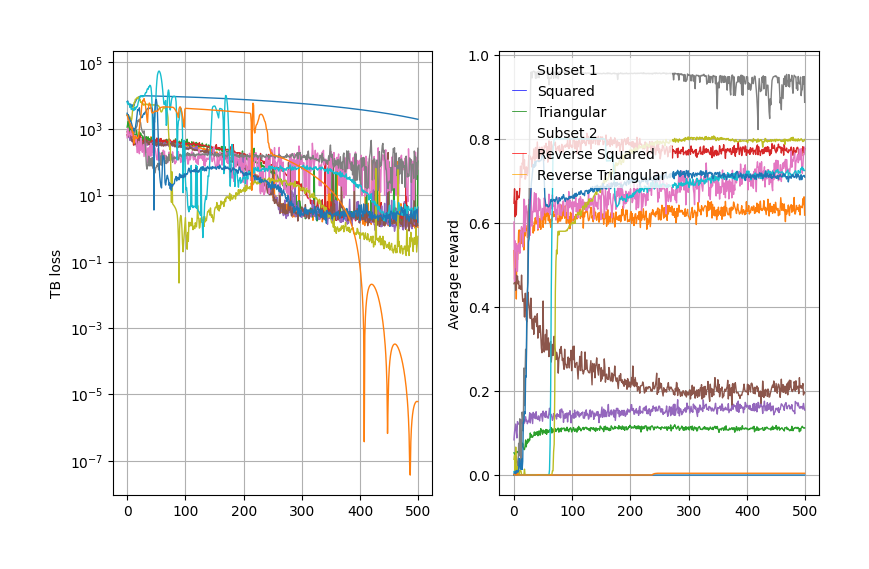

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(4*2,5))

for i, savename in enumerate(vanillasaves):
    label = savename.split("_")[0]
    ax = plot_save(ax, savename,label)


ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[0].grid()
ax[1].set_ylabel('Average reward')
ax[1].grid()
#ax[1].set_xlabel('Iteration')
plt.tight_layout()
#plt.savefig(f"../images/vanilla_{number}_plots.pdf", bbox_inches="tight")
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
header1 = Line2D([0], [0], color='none', label='Atom-Based')
header2 = Line2D([0], [0], color='none', label='Fragment-Based')
plt.legend(handles=[header1, plt.Line2D([], [], color='blue', label='Squared'),
                    plt.Line2D([], [], color='green', label='Triangular'),
                    header2, plt.Line2D([], [], color='red', label='Reverse Squared'),
                    plt.Line2D([], [], color='orange', label='Reverse Triangular')],
           loc='upper left', frameon=True)